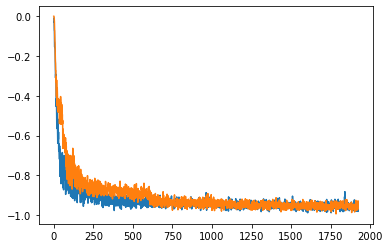

In [10]:
import os, sys
currentdir = os.path.dirname(os.getcwd())
sys.path.append(currentdir)

import numpy as np
import matplotlib.pyplot as plt

import os, sys
currentdir = os.path.dirname(os.getcwd())
sys.path.append(currentdir)
loss = np.load('./saved/model_001_loss.npy')
loss2 = np.load('./saved/model_003_loss.npy')
plt.figure()
plt.plot(loss)
plt.plot(loss2)
plt.show()

In [13]:
import torch
from datasets.dataloader_potsdam import Potsdam, PotsdamDataLoader
from datasets.dataloader_cocostuff import get_coco_dataloader
from model.model import ARSegmentationNet1, ARSegmentationNet2, ARSegmentationNet3, ARSegmentationNet4


# Potsdam
# path = '/mnt/D2/Data/potsdam/preprocessed/'
# validation_dataset = Potsdam(path, coarse_labels=False, split='labelled_test', is_test=True)
# validation_loader = PotsdamDataLoader(validation_dataset, batch_size=10)
# in_channels = 4
# num_classes = 6
# conv1_stride=2
        
# Potsdam-3
path = '/mnt/D2/Data/potsdam/preprocessed/'
validation_dataset = Potsdam(path, coarse_labels=True, split='labelled_test', is_test=True)
validation_loader = PotsdamDataLoader(validation_dataset, batch_size=10)
in_channels = 4
num_classes = 3
conv1_stride=1

# # Coco-Stuff 15
# validation_loader = get_coco_dataloader(10, version='CocoStuff15', split='val')
# in_channels = 3
# num_classes = 15
# conv1_stride=2

# # Coco-Stuff 3
# validation_loader = get_coco_dataloader(10, version='CocoStuff3', split='val')

# in_channels = 3
# num_classes = 4 # this is confusing since it's called coco-stuff 3
# conv1_stride=2

# # get a batch of images and labels from the dataloader
dataiter = iter(validation_loader)
print(len(validation_loader.dataset))

855


In [32]:
images, labels = dataiter.next()
labels = labels.detach().numpy()

# load the model architecture and trained weights
state_dict = torch.load('./saved/model_003.pth')
model = ARSegmentationNet2(in_channels=in_channels, num_classes=num_classes, stride=conv1_stride)
model.load_state_dict(state_dict)

# run the model on the images
out = model(images, 0).detach().numpy()
print(out.shape)
out_preds = np.argmax(out, axis=1)

# labels[labels == 4] = 0 # merge road and cars classes...? this seems questionable but that's how they do
# labels[labels == 5] = 1 # merge buildings and clutter classes
# labels[labels == 3] = 2 # merge vegetation and trees classes

(10, 3, 200, 200)


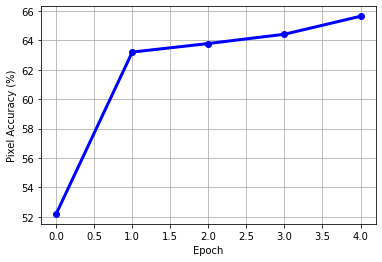

In [33]:
from scipy.optimize import linear_sum_assignment as linear_assignment
import pickle

f = open('./saved/model_003_confusion_matrix.pkl', 'rb')
dists = pickle.load(f)
f.close()

# f = open('./saved/model_021_confusion_matrix.pkl', 'rb')
# dists2 = pickle.load(f)
# f.close()

# f = open('./saved/model_022_confusion_matrix.pkl', 'rb')
# dists3 = pickle.load(f)
# f.close()


acc = np.zeros((5,))
for i,d in enumerate(dists):
    ri, ci = linear_assignment(d, maximize=True)
    corr = d[ri, ci].sum()
    acc[i] = corr/d.sum()
    
# acc2 = np.zeros((10,))
# for i,d in enumerate(dists2):
#     ri, ci = linear_assignment(d, maximize=True)
#     corr = d[ri, ci].sum()
#     acc2[i] = corr/d.sum()
    
# acc3 = np.zeros((10,))
# for i,d in enumerate(dists3):
#     ri, ci = linear_assignment(d, maximize=True)
#     corr = d[ri, ci].sum()
#     acc3[i] = corr/d.sum()
    
plt.figure()
plt.plot(acc*100, 'bo-', linewidth=3)
# plt.plot(acc2*100, 'ro-', linewidth=3)
# plt.plot(acc3*100, 'ko-', linewidth=3)
plt.grid()
plt.ylabel("Pixel Accuracy (%)")
plt.xlabel("Epoch")
plt.show()
    

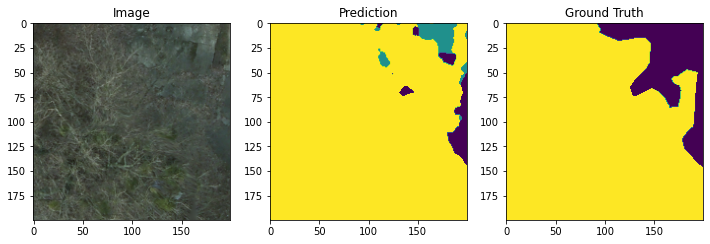

In [41]:
img = 1

out_labels = out_preds.copy()
# out_labels[out_preds == ci[0] ] = ri[0]
# out_labels[out_preds == ci[1] ] = ri[1]
# out_labels[out_preds == ci[2] ] = ri[2]
# out_labels[out_preds == ci[3] ] = ri[3]

plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(images[img,:3,:,:].permute(1,2,0))
plt.title("Image")
plt.subplot(132)
plt.imshow(out_labels[img,:,:])
plt.title("Prediction")
plt.subplot(133)
plt.imshow(labels[img,:,:])
plt.title("Ground Truth")
plt.show()
# plt.savefig("out3.png", dpi=300)

In [22]:
ci

array([0, 1, 2])

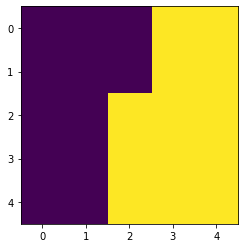

In [14]:
def create_masks(H):
    '''creates the attention mask for each ordering'''
    
    # allocate space
    mask = np.zeros((8, H, H))
    
    # create attention masks for each ordering
    for ordering in range(1,9):
        
        a = np.ones((H,H))
        a[H//2, H//2+1:]=0
        a[H//2+1:,:] = 0
        
        if ordering == 2:
            a = np.flip(np.rot90(a, 1), 0)  # CCW 90, flip V
        elif ordering==3:
            a = np.flip(a, 1)               # flip H
        elif ordering==4:
            a = np.rot90(a, 3)              # CCW 270
        elif ordering==5:
            a = np.rot90(a, 1)              # CCW 90
        elif ordering==6:
            a = np.flip(a, 0)               # flip V
        elif ordering==7:
            a = np.rot90(a, 2)              # CCW 180
        elif ordering==8:
            a = np.flip(np.rot90(a, 3), 0)  # CCW 270, flip V
            
        mask[ordering-1,:,:] = a
    
    return mask

msk = create_masks(5)

plt.figure()
plt.imshow(msk[7,:,:])
plt.show()

In [17]:
a = validation_dataset.__getitem__(12)[0].unsqueeze(0)
b = model(a, 0)